In [1]:
from __future__ import division
import keras
import numpy as np
import pandas as pd
from utils import fx_1minute_bar_catalog, load_1minute_fx_bars, logreturn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Using TensorFlow backend.


In [2]:
#filename = 'moving_average_500_500_500_500_20172901-194204.h5'
filename = 'moving_average_500_500_500_500_20172901-221323.h5'
model = keras.models.load_model(filename)

In [3]:
catalog = fx_1minute_bar_catalog()
catalog

defaultdict(list,
            {'EURGBP': ['2012', '2013', '2014', '2015', '2016'],
             'EURJPY': ['2012', '2013', '2014', '2015', '2016'],
             'EURUSD': ['2012', '2013', '2014', '2015', '2016'],
             'GBPCHF': ['2012', '2013', '2014', '2015', '2016'],
             'GBPJPY': ['2012', '2013', '2014', '2015', '2016'],
             'GBPUSD': ['2012', '2013', '2014', '2015', '2016'],
             'USDJPY': ['2012', '2013', '2014', '2015', '2016'],
             'XAGUSD': ['2012', '2013', '2014', '2015', '2016'],
             'XAUGBP': ['2012', '2013', '2014', '2015', '2016'],
             'XAUUSD': ['2012', '2013', '2014', '2015', '2016']})

In [124]:
ds = load_1minute_fx_bars('XAUGBP', 2015)[['close']]
#ds['close'] = 1/ds['close']

In [125]:
def ewmasig(x, lp, sp):
    volp = lp*5
    lma = x.ewm(span=lp).mean()
    sma = x.ewm(span=sp).mean()
    return np.tanh(15000 * (sma - lma) * lma.ewm(volp).std() / (np.sqrt(lp) *sma.ewm(volp).std()))

def masig(x, lp, sp):
    volp = lp*5
    lma = x.rolling(lp).mean()
    sma = x.rolling(sp).mean()
    return np.tanh(10000 * (sma - lma) * lma.rolling(volp).std() / (np.sqrt(lp) *sma.rolling(volp).std()))

In [126]:
px = logreturn(ds['close'], ds['close'].shift(1)).cumsum()
ds['px'] = px
for period in [2,4,8,16,32,64,128,256]:
    ds['lret-{}'.format(period)] = np.tanh(logreturn(px, px.shift(period)))
    ds['ma{}-{}'.format(2*period, period)] = masig(px, 2*period, period)
    ds['ewma{}-{}'.format(2*period, period)] = ewmasig(px, 2*period, period)


In [127]:
price = ds['close']
ds = ds.drop('close',axis=1).fillna(0.0)

In [128]:
ds.shape

(352213, 25)

In [129]:
%%time
pred = model.predict(ds.as_matrix())

CPU times: user 1min 19s, sys: 4.61 s, total: 1min 24s
Wall time: 30.3 s


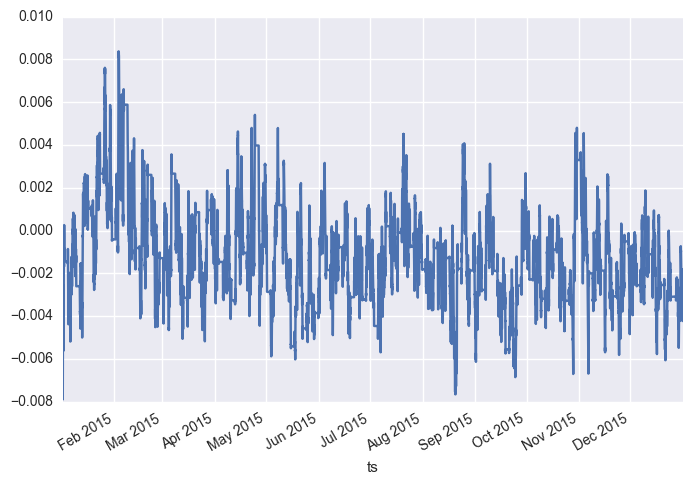

In [130]:
idx = ds.index
plt.figure()#figsize=(20,12))
#pp = pd.Series((-2*pred[:,0] + -1*pred[:,1] + 1*pred[:,3] + 2*pred[:,4]), index=idx)
pp = pd.Series((-1*pred[:,0]  + 1*pred[:,4]), index=idx)
pp.ewm(1000).mean().plot()

In [131]:
fut_return = price.shift(-10)- price
fut_return.mean()

-0.001163590315812188

sig 0.0132623515416
ewma: 1 0.0124522505487
ma: 1 0.0132623515416
ewma: 2 0.011422446714
ma: 2 0.0123243129672
ewma: 3 0.0105854294256
ma: 3 0.0117863277712
ewma: 4 0.00984744593317
ma: 4 0.011417733523
ewma: 5 0.00906448837744
ma: 5 0.0105014437696
ewma: 6 0.00828391580992
ma: 6 0.0105774226795
ewma: 7 0.00782048988793
ma: 7 0.00938907391476
ewma: 8 0.00737046532823
ma: 8 0.00907800331059
ewma: 9 0.00730044888885
ma: 9 0.00878294619864


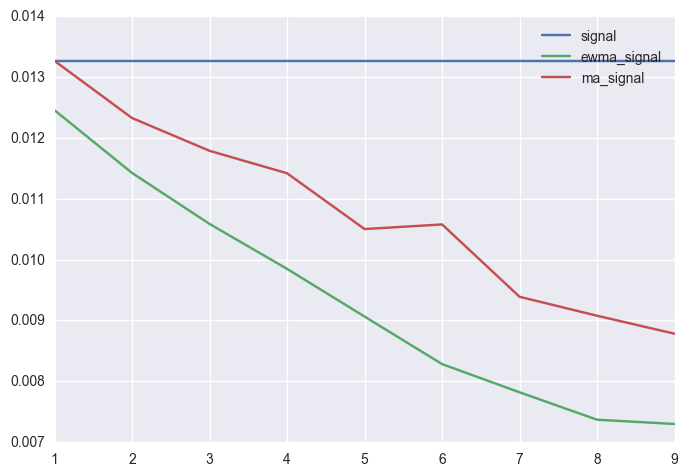

In [132]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).mean()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).mean()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).mean()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

In [133]:
fut_return.std()

0.60575268028067963

sig 0.605608597318
ewma: 1 0.605625795875
ma: 1 0.605608597318
ewma: 2 0.605646093816
ma: 2 0.605628412884
ewma: 3 0.605661301372
ma: 3 0.60563912167
ewma: 4 0.605673749759
ma: 4 0.605646182688
ewma: 5 0.605685973447
ma: 5 0.605662763408
ewma: 6 0.605697152179
ma: 6 0.605661441257
ewma: 7 0.605703312999
ma: 7 0.605681028805
ewma: 8 0.605708956265
ma: 8 0.605685771036
ewma: 9 0.605709804203
ma: 9 0.605690121473


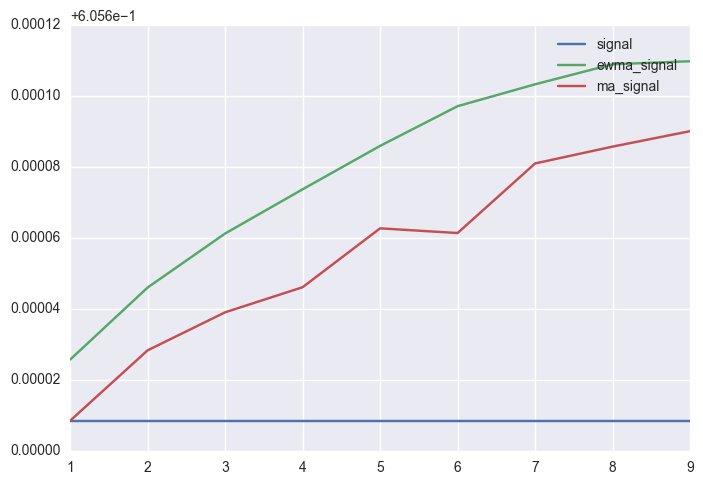

In [134]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).std()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).std()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).std()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

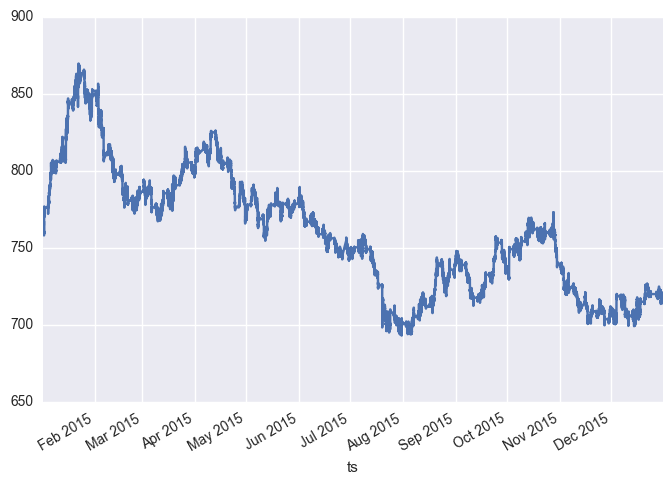

In [135]:
price.plot()

- expected return
- trading cost. frequency


In [31]:
print sx

[0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415]


----------------------

In [138]:
pred.max(axis=0)

array([ 0.37622789,  0.26329806,  0.59318876,  0.26616082,  0.4128882 ], dtype=float32)

In [140]:
np.argmax(pred, axis=1)

array([2, 2, 2, ..., 2, 2, 2])

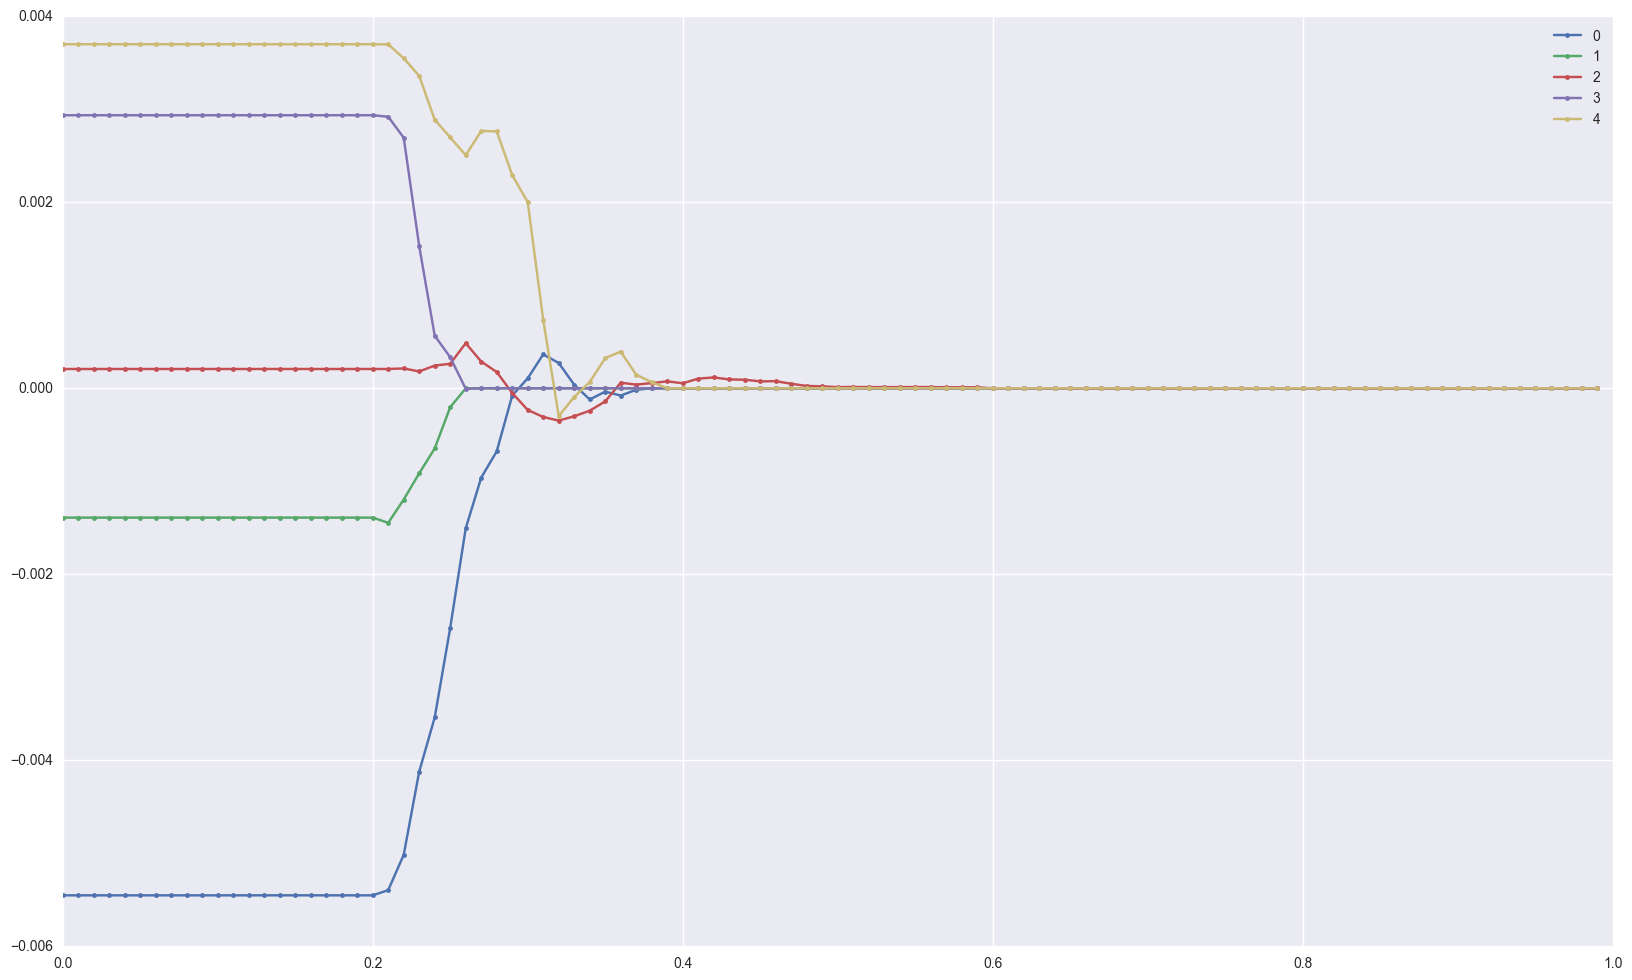

In [144]:
FIGSIZE = (20,12)
plt.figure(figsize=FIGSIZE)
STEPS = 100
for idx in range(5):
    fracs  = []
    results = []
    for i in range (STEPS):
        frac = i/STEPS
        result = ((np.argmax(pred, axis=1) == idx) * (pred[:,idx] > frac) * fut_return).mean()
        #result = ((np.argmax(pred, axis=1) == idx) *  fut_return).mean()
        fracs.append(frac)
        results.append(result)
    #print fracs, results
    plt.plot(fracs,results,'.-', label=str(idx))
plt.legend()
plt.show()
    

In [147]:
pred_categories = np.argmax(pred, axis=1)

In [148]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()

0 -54.5223566704
1 -13.9065796025
2 2.07333276234
3 29.3607921703
4 36.9948113403


In [311]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()
 

0 -1.26150900888
1 -0.148767066005
2 -0.0435222524612
3 0.00420670101779
4 1.44959162633


In [154]:
INITIAL = 1000.0
RISK = 0.20
balance = INITIAL
holdings = 0
holding_period=10
countdown = 0
BPS = 1e-4
cost =10 * BPS

idx = ds.index
for i in range(len(idx)):
    prediction = pp[i]
    prx = price[i]
    amt = balance * RISK / prx

    #print i, prediction,prx
    if countdown == 0 and holdings == 0:

        if prediction > 0:
            balance -= prx *(1+cost) * amt
            holdings += amt
            #print "bought",amt,"at",prx 
        else:
            balance += prx *(1-cost)* amt
            holdings -= amt
            #print "sold",amt,"for",prx 
        countdown = holding_period
    elif countdown == 0:
        # dispose of assets if prediction opposite to current holding
        if np.sign(prediction) != np.sign(holdings):
            balance += prx * holdings
            # print "disposed of ", holdings, "at", prx,". balance=", balance
            holdings = 0
    else:
        countdown -= 1

print balance

448.289580195
